# Build a Multi-Omics Container for GCN Training
The goal of this little notebook is to create one HDF5 container that contains a feature matrix consisting of our multi-omics data:
* Mutation Frequencies
* Gene Expression
* Methylation

We then can train our network using the iref or CPDB PPI together with the multi-omics information.

In [1]:
import h5py, sys, os
import re
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn
import networkx as nx
import mygene

sys.path.append(os.path.abspath('../../GCN'))
import gcnPreprocessing
import gcnIO
plt.rc('font', family='Times New Roman')
%matplotlib inline

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/sasse/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Parameters
* `use_quantile_norm`: Normalize the data with (normal) quantile normalization instead of simple MinMax normalization
* `use_ncg_labels`: Use labels from the [network of cancer genes](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-018-1612-0) (Currently no choice given)
* `ppi_network_to_use`: Which underlying PPI network to use (can be [CPDB](http://cpdb.molgen.mpg.de/CPDB) or [IREF](http://irefindex.org/wiki/index.php?title=iRefIndex))
* `remove_blood_cancer_genes`: Whether or not to remove blood cancer genes according to [COSMIC CGC](https://cancer.sanger.ac.uk/cosmic/download) from the positive labels (known cancer genes) or not (True for removal, False otherwise

In [2]:
# PARAMETERS
use_quantile_norm = False # quantile or MinMax normalization
ppi_network_to_use ='CPDB'
remove_blood_cancer_genes = False

## Functions

In [3]:
def get_gene_symbols(list_of_ensembl_ids):
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_ensembl_ids,
                       scopes='ensembl.gene',
                       fields='symbol',
                       species='human', returnall=True
                      )

    def get_symbol_and_ensembl(d):
        if 'symbol' in d:
            return [d['query'], d['symbol']]
        else:
            return [d['query'], None]

    node_names = [get_symbol_and_ensembl(d) for d in res['out']]
    # now, retrieve the names and IDs from a dictionary and put in DF
    node_names = pd.DataFrame(node_names, columns=['Ensembl_ID', 'Symbol']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)
    return node_names

def get_ensembl_ids(list_of_gene_symbols):
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_gene_symbols,
                       scopes='symbol, refseq, uniprot',
                       fields='ensembl.gene',
                       species='human', returnall=True
                      )

    # now, retrieve the names and IDs from a dictionary and put in DF
    def get_name_and_id(x):
        if 'ensembl' in x:
            ens_id = x['ensembl'][0]['gene'] if type(x['ensembl']) is list else x['ensembl']['gene']
            symbol = x['query']
            return [symbol, ens_id]
        else:
            return [x['query'], None]

    ens_ids = [get_name_and_id(x) for x in res['out']]
    
    node_names = pd.DataFrame(ens_ids, columns=['Symbol', 'Ensembl_ID']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)
    node_names.drop_duplicates(inplace=True)
    return node_names

## Load the data from disk and unify

In [4]:
# Load mutation data
mutations = pd.read_csv('../../data/pancancer/TCGA/mutation/mutation_frequencies_mean.tsv', sep='\t')
mutations.set_index('Name', inplace=True)
mutations.columns = ['Ensembl_ID'] + mutations.columns[1:].tolist()

# Load methylation
methylation = pd.read_csv('../../data/pancancer/TCGA/methylation/methylation_RATIO_mean.tsv', sep='\t')
methylation.columns = ['Name'] + [i.upper() for i in methylation.columns[1:]]
methylation.set_index('Name', inplace=True)

# Load expression
expression = pd.read_csv('../../data/pancancer/TCGA/expression/expression_gtexnormfc_mean.tsv', sep='\t')
expression.columns = ['Name'] + [i.upper() for i in expression.columns[1:]]
expression.set_index('Name', inplace=True)

# Load PPI network
ppi_network = None
if ppi_network_to_use.upper() == 'IREF':
    net_file = '../../data/pancancer/hotnet2/networks/irefindex9/irefindex9_edge_list'
    name_file = '../../data/pancancer/hotnet2/networks/irefindex9/irefindex9_index_gene'
    edgelist = pd.read_csv(net_file, sep=' ', header=None,
                           names=['from', 'to', 'weight'])
    index = pd.read_csv(name_file, sep=' ', header=None, names=['name'])
    # build network and relabel nodes to match with real names
    ppi_graph = nx.from_pandas_edgelist(edgelist, source='from', target='to', edge_attr=None)
    _ = nx.relabel_nodes(ppi_graph, index.to_dict()['name'], copy=False)
    ppi_network = nx.to_pandas_adjacency(G=ppi_graph)
    symbols_network_genes = get_ensembl_ids(ppi_network.index)
    # Remove nodes from network that don't have corresponding gene names
    nodes_not_translatable = ppi_network[~ppi_network.index.isin(symbols_network_genes.Symbol)].index
    print ("Not translatable: {}".format(nodes_not_translatable.shape[0]))
    ppi_graph.remove_nodes_from(nodes_not_translatable)
    ppi_network = nx.to_pandas_adjacency(G=ppi_graph)
    assert ((ppi_network.index == symbols_network_genes.Symbol).all())

elif ppi_network_to_use.upper() == 'CPDB':
    ppi_network = pd.read_csv('../../data/networks/CPDB_symbols_edgelist.tsv', sep='\t')
    ppi_graph = nx.from_pandas_edgelist(df=ppi_network, source='partner1', target='partner2', edge_attr='confidence')
    ppi_network = nx.to_pandas_adjacency(G=ppi_graph)
else:
    print ("No PPI network named {}".format(ppi_network_to_use))

print ("Edges: {}\tNodes: {}".format(ppi_graph.number_of_edges(), ppi_graph.number_of_nodes()))

# Next, I have to remove cancer types only present in a subset of the data
relevant_ctypes = list(set(mutations.columns[1:]).intersection(*[set(expression.columns), set(methylation.columns)]))
mutations = mutations[relevant_ctypes]
methylation = methylation[relevant_ctypes]
expression = expression[relevant_ctypes]

# Finally, reindex to the network nodes such that everything is in the same order and non-network genes are removed
mutations_ppiindex = mutations.reindex(ppi_network.index, fill_value=0)
methylation_ppiindex = methylation.reindex(ppi_network.index, fill_value=0)
expression_ppiindex = expression.reindex(ppi_network.index, fill_value=0)

# print some stats
mut_nodes = mutations[mutations.index.isin(ppi_network.index)].shape[0]
meth_nodes = methylation[methylation.index.isin(ppi_network.index)].shape[0]
ge_nodes = expression[expression.index.isin(ppi_network.index)].shape[0]
print ("Network has {} nodes/genes".format(ppi_network.shape[0]))
print ("* {} genes in network have mutations".format(mut_nodes))
print ("* {}  genes in network have methylation data".format(meth_nodes))
print ("* {} genes in network have gene expression".format(ge_nodes))

Edges: 252189	Nodes: 13627
Network has 13627 nodes/genes
* 13283 genes in network have mutations
* 12406  genes in network have methylation data
* 11309 genes in network have gene expression


In [5]:
# verify that the genes are the same and that they are in the same order
print ((mutations_ppiindex.index == methylation_ppiindex.index).all())
print ((mutations_ppiindex.index == expression_ppiindex.index).all())
print ((methylation_ppiindex.index == expression_ppiindex.index).all())
print ((mutations_ppiindex.index == ppi_network.index).all())
if ppi_network_to_use.upper() == 'IREF':
    print ((ppi_network.index == symbols_network_genes.Symbol).all())

True
True
True
True


## Join Multi-Omics to form one feature matrix

In [6]:
if use_quantile_norm:
    scaler = preprocessing.QuantileTransformer(output_distribution='normal')
    ge_norm = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(scaler.fit_transform(expression_ppiindex))
    #mutfreq_norm = scaler.fit_transform(mutfreq_features)
    mutfreq_norm = preprocessing.MinMaxScaler().fit_transform(mutations_ppiindex)
    meth_norm = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(methylation_ppiindex)
else:
    scaler = preprocessing.MinMaxScaler()
    ge_norm = scaler.fit_transform(np.abs(expression_ppiindex))
    mutfreq_norm = scaler.fit_transform(mutations_ppiindex)
    meth_norm = scaler.fit_transform(np.abs(methylation_ppiindex))

multi_omics_features = np.concatenate((mutfreq_norm, meth_norm, ge_norm), axis=1)
multi_omics_features_raw = np.concatenate((mutations_ppiindex, methylation_ppiindex, expression_ppiindex), axis=1)

In [7]:
np.save('../../data/pancancer/multiomics_features_raw.npy', multi_omics_features_raw)
np.save('../../data/pancancer/multiomics_features.npy', multi_omics_features)

In [8]:
mutations_ppiindex[mutations_ppiindex.index.str.contains('CREB')]

,BRCA,PRAD,STAD,COAD,KIRC,CESC,KIRP,BLCA,HNSC,LUSC,LIHC,ESCA,THCA,UCEC,LUAD,READ
CREBBP,0.016546,0.006085,0.041775,0.030675,0.008955,0.075812,0.021583,0.125313,0.061630,0.069182,0.016667,0.044199,0.004073,0.058680,0.035514,0.015748
CREB1,0.002068,0.000000,0.000000,0.003067,0.000000,0.010830,0.014388,0.000000,0.001988,0.004193,0.002778,0.000000,0.002037,0.002445,0.005607,0.000000
CREBZF,0.006205,0.002028,0.005222,0.003067,0.002985,0.010830,0.010791,0.010025,0.001988,0.004193,0.013889,0.027624,0.002037,0.002445,0.001869,0.000000
CREB3,0.001034,0.000000,0.005222,0.009202,0.000000,0.003610,0.007194,0.015038,0.001988,0.004193,0.005556,0.000000,0.000000,0.002445,0.003738,0.015748
CREB5,0.007239,0.004057,0.013055,0.021472,0.005970,0.014440,0.000000,0.030075,0.011928,0.006289,0.005556,0.027624,0.000000,0.017115,0.022430,0.000000
CREB3L1,0.004137,0.000000,0.005222,0.006135,0.000000,0.003610,0.003597,0.000000,0.001988,0.006289,0.000000,0.011050,0.000000,0.007335,0.000000,0.000000
CREB3L3,0.005171,0.002028,0.005222,0.000000,0.002985,0.007220,0.003597,0.007519,0.017893,0.014675,0.016667,0.000000,0.004073,0.007335,0.005607,0.007874
CREBL2,0.002068,0.002028,0.000000,0.000000,0.000000,0.003610,0.000000,0.005013,0.000000,0.002096,0.000000,0.005525,0.000000,0.009780,0.000000,0.000000
CREB3L4,0.004137,0.002028,0.002611,0.006135,0.002985,0.010830,0.000000,0.020050,0.003976,0.006289,0.002778,0.000000,0.000000,0.002445,0.005607,0.015748
CREB3L2,0.005171,0.004057,0.010444,0.012270,0.008955,0.010830,0.003597,0.015038,0.005964,0.016771,0.002778,0.000000,0.000000,0.004890,0.013084,0.007874


In [9]:
multi_omics_features[ppi_network.index.str.contains('NR4A3')]

array([[2.31213873e-02, 1.66666667e-02, 8.49858357e-03, 2.61780105e-03,
        5.91715976e-03, 5.42635659e-02, 0.00000000e+00, 9.03614458e-03,
        2.48756219e-03, 4.60829493e-03, 7.87401575e-03, 3.52941176e-02,
        0.00000000e+00, 9.49367089e-03, 1.48423006e-02, 0.00000000e+00,
        6.09899270e-03, 8.56482137e-03, 3.44766614e-02, 9.90613057e-03,
        9.00817162e-03, 1.20050454e-02, 2.94419143e-03, 9.74055331e-04,
        2.71213037e-03, 1.60863075e-02, 2.34429508e-03, 2.08378713e-02,
        4.76068266e-03, 1.92082567e-03, 7.31654502e-05, 1.20567916e-02,
        3.95573752e-01, 3.80734576e-01, 3.67334819e-01, 2.67885387e-01,
        3.51075739e-01, 1.93237996e-01, 5.30611510e-01, 5.37846815e-01,
        1.95078351e-01, 4.71735192e-01, 0.00000000e+00, 0.00000000e+00,
        5.82560594e-01, 3.29775112e-01, 4.94960483e-01, 2.40375218e-01]])

### Plot Distribution of Features

In [10]:
expression_ppiindex.shape, mutations_ppiindex.shape, methylation_ppiindex.shape, ppi_network.shape

((13627, 16), (13627, 16), (13627, 16), (13627, 13627))

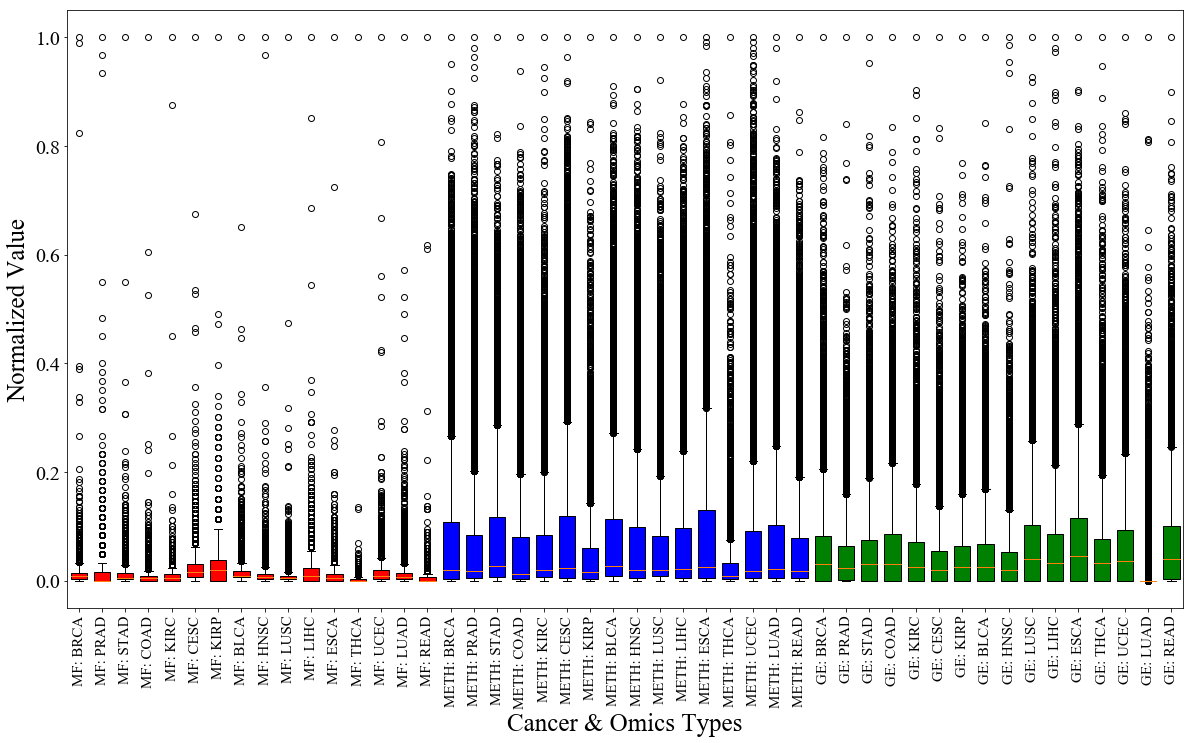

In [11]:
# plot distribution of features
fig = plt.figure(figsize=(20, 11))

# mutation frequencies
feat_names_mut = ['MF: ' + i.upper() for i in mutations_ppiindex.columns]

# gene expression
feat_names_ge = ['GE: ' + i.upper() for i in expression_ppiindex.columns]

# methylation
feat_names_meth = ['METH: ' + i.upper() for i in methylation_ppiindex.columns]
feat_names_all = feat_names_mut + feat_names_meth + feat_names_ge

# plot
x = plt.boxplot(multi_omics_features, widths=0.7, patch_artist=True)
_ = plt.xticks(range(1, multi_omics_features.shape[1]+1), feat_names_all, rotation='vertical', fontsize=15)
_ = plt.setp(plt.gca().get_yticklabels(), fontsize=20)

# fill with colors
colors = ['red']*len(feat_names_mut) + ['blue']*len(feat_names_meth) + ['green']*len(feat_names_ge)
for patch, color in zip(x['boxes'], colors):
    patch.set_facecolor(color)

#plt.gca().set_ylim([-2, 2])
plt.xlabel('Cancer & Omics Types', fontsize=25)
plt.ylabel('Normalized Value', fontsize=25)
#plt.title('Distribution of Multi-Omics Data', fontsize=30)

if use_quantile_norm:
    fig.savefig('multi_omics_feature_distribution_quantiled.png', dpi=300)
else:
    fig.savefig('multi_omics_feature_distribution_normminmax.png', dpi=300)


Text(0, 0.5, 'Abs. Foldchange')

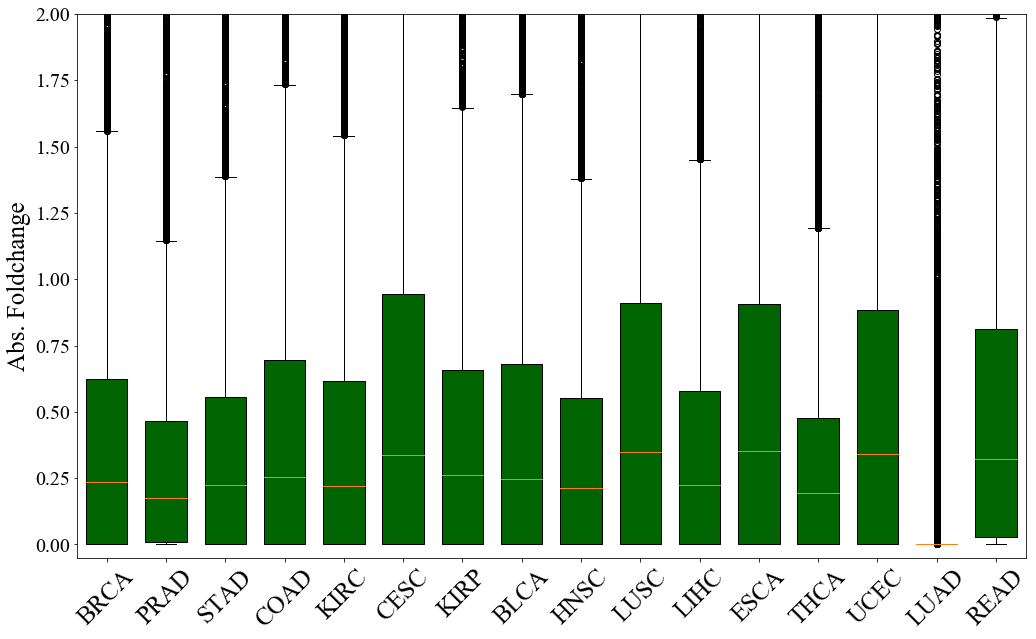

In [12]:
fig = plt.figure(figsize=(17, 10))

# plot
x = plt.boxplot(np.abs(expression_ppiindex.values), widths=0.7, patch_artist=True)
_ = plt.xticks(range(1, expression_ppiindex.shape[1]+1), [i.upper() for i in expression_ppiindex.columns], rotation=45, fontsize=25)
_ = plt.setp(plt.gca().get_yticklabels(), fontsize=20)

colors = ['darkgreen']*len(feat_names_ge)
for patch, color in zip(x['boxes'], colors):
    patch.set_facecolor(color)

plt.gca().set_ylim([-0.05, 2])
#plt.gca().set_ylim([-0.05, 1])
#plt.gca().set_ylim([-0.005, 0.05])
plt.xlabel('', fontsize=25)
#plt.ylabel('Frequency', fontsize=25)
plt.ylabel('Abs. Foldchange', fontsize=25)
#plt.title('Distribution of Multi-Omics Data', fontsize=30)
#fig.savefig('../../plots/input_ge.png', dpi=300)

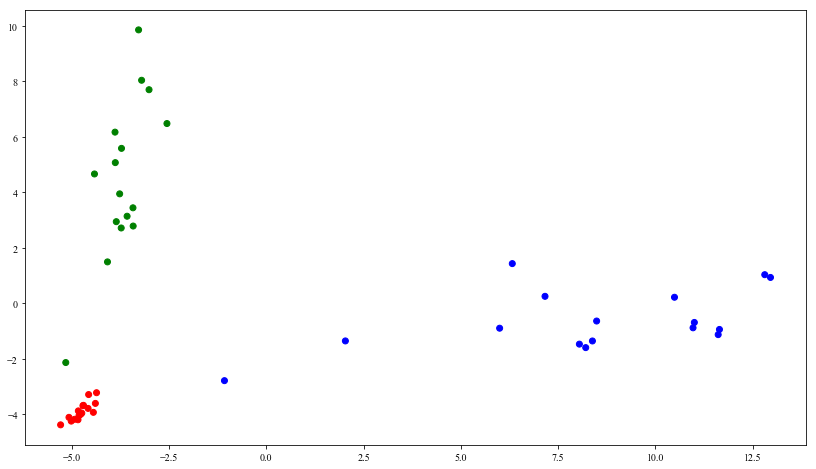

In [13]:
from sklearn.decomposition import PCA

emb = PCA(n_components=2).fit_transform(multi_omics_features.T)
fig = plt.figure(figsize=(14, 8))
plt.scatter(x=emb[:, 0], y=emb[:, 1], c=['red']*len(feat_names_mut)+['blue']*len(feat_names_meth)+['green']*len(feat_names_ge))

## Get Labels

In [14]:
nodes = get_ensembl_ids(ppi_network.index)
nodes.head()

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-13627...done.
Finished.
17 input query terms found dup hits:
	[('TEC', 2), ('IGHM', 3), ('MEMO1', 2), ('KCNA6', 2), ('MMD2', 2), ('HBD', 2), ('IGKV3-20', 3), ('PO
2 input query terms found no hit:
	['FUK', 'PRSS42']


,Symbol
Ensembl_ID,
ENSG00000167323,STIM1
ENSG00000144935,TRPC1
ENSG00000089250,NOS1
ENSG00000058668,ATP2B4
ENSG00000069431,ABCC9


In [15]:
nodes.columns = ['Name']

known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name
known_cancer_genes_innet.shape, len(known_cancer_genes)

((654,), 711)

In [16]:
if remove_blood_cancer_genes:
    # load cgc
    cgc = pd.read_csv('../../data/pancancer/cosmic/cancer_gene_census.csv')
    cgc.dropna(subset=['Tissue Type'], inplace=True)

    # find blood cancer genes based on these abbreviations (E=Epithelial, M=Mesenchymal, O=Other, L=Leukaemia/lymphoma)
    pattern = '|'.join(['E', 'O', 'M', 'E;'])
    non_blood_cancer_genes = cgc[cgc['Tissue Type'].str.contains(pattern)]
    blood_cancer_genes = cgc[~cgc['Tissue Type'].str.contains(pattern)]
    known_cancer_genes_innet = non_blood_cancer_genes[non_blood_cancer_genes['Gene Symbol'].isin(known_cancer_genes_innet)]['Gene Symbol']
    print ("Left with {} known cancer genes after blood removal".format(known_cancer_genes_innet.shape[0]))

In [17]:
print ("{} genes are in network".format(nodes.shape[0]))

# get rid of the positives (known cancer genes)
not_positives = nodes[~nodes.Name.isin(known_cancer_genes_innet)]
print ("{} genes are in network but not in positives (known cancer genes from NCG)".format(not_positives.shape[0]))

# get rid of OMIM genes associated with cancer
omim_cancer_genes = pd.read_csv('../../data/pancancer/OMIM/genemap_search_cancer.txt',
                                sep='\t', comment='#', header=0, skiprows=3)
# use fact that nan != nan for filtering out NaN
sublists = [sublist for sublist in omim_cancer_genes['Gene/Locus'].str.split(',') if sublist == sublist]
omim_cancer_geneset = [item.strip() for sublist in sublists for item in sublist]
not_omim_not_pos = not_positives[~not_positives.Name.isin(omim_cancer_geneset)]
print ("{} genes are also not in OMIM cancer genes".format(not_omim_not_pos.shape[0]))

# get rid of all the OMIM disease genes
omim_genes = pd.read_csv('../../data/pancancer/OMIM/genemap2.txt', sep='\t', comment='#', header=None)
omim_genes.columns = ['Chromosome', 'Genomic Position Start', 'Genomic Position End', 'Cyto Location',
                      'Computed Cyto Location', 'Mim Number', 'Gene Symbol', 'Gene Name',
                      'Approved Symbol', 'Entrez Gene ID', 'Ensembl Gene ID', 'Comments',
                      'Phenotypes', 'Mouse Gene Symbol/ID']
omim_gene_names = []
for idx, row in omim_genes.iterrows():
    gene_names = row['Gene Symbol'].strip().split(',')
    omim_gene_names += gene_names
omim_gene_names = list(set(omim_gene_names))
not_omim_not_pos = not_omim_not_pos[~not_omim_not_pos.Name.isin(omim_gene_names)]
print ("{} genes are in network but not in oncogenes and not in OMIM".format(not_omim_not_pos.shape[0]))

# remove COSMIC cancer gene census genes
cosmic_gene_scores = pd.read_csv('../../data/pancancer/cosmic/cancer_gene_census.csv', header=0)
not_omim_cosmic_pos = not_omim_not_pos[~not_omim_not_pos.Name.isin(cosmic_gene_scores['Gene Symbol'])]
print ("{} genes are also not in COSMIC cancer gene census".format(not_omim_cosmic_pos.shape[0]))

# remove COSMIC highly mutated genes
cosmic_prcoding_mutations = pd.read_csv('../../data/pancancer/cosmic/CosmicMutantExportCensus.tsv.gz',
                                        compression='gzip', sep='\t')
non_pos_omim_cosmiccgc_cosmic_mutated = not_omim_cosmic_pos[~not_omim_cosmic_pos.Name.isin(cosmic_prcoding_mutations['Gene name'])]
print ("{} genes are also not in COSMIC mutated genes".format(non_pos_omim_cosmiccgc_cosmic_mutated.shape[0]))

# remove genes that belong to KEGG pathways in cancer
kegg_cancer_pathway_genes = pd.read_csv('../../data/pancancer/KEGG/KEGG_genes_in_pathways_in_cancer.txt',
                                        skiprows=2, header=None, names=['Name'])
not_pos_omim_cosmic_kegg = non_pos_omim_cosmiccgc_cosmic_mutated[~non_pos_omim_cosmiccgc_cosmic_mutated.Name.isin(kegg_cancer_pathway_genes.Name)]
print ("{} genes are also not in KEGG cancer pathways".format(not_pos_omim_cosmic_kegg.shape[0]))

# get rid of genes that are not candidate cancer genes
negatives = not_pos_omim_cosmic_kegg[~not_pos_omim_cosmic_kegg.Name.isin(candidate_cancer_genes)]
print ("{} genes are also not in NCG candidate cancer genes".format(negatives.shape[0]))

# collect genes in KEGG cancer modules
kegg_cancer_module_genes = []
count = 0
with open('../../data/pancancer/KEGG/KEGG_cancer_modules.gmt', 'r') as f:
    for line in f:
        for item in line.split('\t')[2:]:
            kegg_cancer_module_genes.append(item.strip())
kegg_cancer_module_genes = list(set(kegg_cancer_module_genes))

# collect genes in KEGG cancer gene neighborhoods
kegg_cancer_neighborhood_genes = []
count = 0
with open('../../data/pancancer/KEGG/KEGG_cancer_neighborhoods.gmt', 'r') as f:
    for line in f:
        for item in line.split('\t')[2:]:
            kegg_cancer_neighborhood_genes.append(item.strip())
kegg_cancer_neighborhood_genes = list(set(kegg_cancer_neighborhood_genes))

negatives = negatives[~negatives.Name.isin(kegg_cancer_module_genes) & ~negatives.Name.isin(kegg_cancer_neighborhood_genes)]
print ("{} genes also not in KEGG cancer modules or KEGG cancer gene neighborhoods".format(negatives.shape[0]))

13627 genes are in network
12973 genes are in network but not in positives (known cancer genes from NCG)
12949 genes are also not in OMIM cancer genes
2352 genes are in network but not in oncogenes and not in OMIM
2352 genes are also not in COSMIC cancer gene census
2352 genes are also not in COSMIC mutated genes
2346 genes are also not in KEGG cancer pathways
2192 genes are also not in NCG candidate cancer genes
1424 genes also not in KEGG cancer modules or KEGG cancer gene neighborhoods


## Do Training and Test Split

In [18]:
y = nodes.Name.isin(known_cancer_genes_innet).values.reshape(-1, 1)
mask = nodes.Name.isin(negatives.Name) | nodes.Name.isin(known_cancer_genes_innet)

In [19]:
y_train, train_mask, y_test, test_mask = gcnPreprocessing.train_test_split(y, mask, 0.25)
y_train, train_mask, y_val, val_mask = gcnPreprocessing.train_test_split(y_train, train_mask, 0.1)
y_train.shape, train_mask.shape, y_test.shape, test_mask.shape, y_val.shape, val_mask.shape

((13627, 1), (13627,), (13627, 1), (13627,), (13627, 1), (13627,))

## Write back everything to container

In [20]:
def write_hdf5_container(fname, adj, F, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, feature_names, features_raw):
    f = h5py.File(fname, 'w')
    string_dt = h5py.special_dtype(vlen=str)
    f.create_dataset('network', data=adj, shape=adj.shape)
    f.create_dataset('features', data=F, shape=F.shape)
    f.create_dataset('gene_names', data=node_names, dtype=string_dt)
    f.create_dataset('y_train', data=y_train, shape=y_train.shape)
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)
    f.create_dataset('y_test', data=y_test, shape=y_test.shape)
    f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
    f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
    f.create_dataset('feature_names', data=np.array(feature_names, dtype=object), dtype=string_dt)
    f.create_dataset('features_raw', data=features_raw, shape=features_raw.shape)
    f.close()

    print ("Container written to {}".format(fname))

In [21]:
multi_omics_features = np.concatenate((mutfreq_norm, meth_norm, ge_norm), axis=1)
nodes['ID'] = nodes.index
nodes = nodes[['ID', 'Name']]
fname = '../../data/pancancer/{}_multiomics_cnaremoved_methsub.h5'.format(ppi_network_to_use.upper())
write_hdf5_container(fname, ppi_network.values, multi_omics_features, nodes, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_all, multi_omics_features_raw)

Container written to ../../data/pancancer/CPDB_multiomics_cnaremoved_methsub.h5


## Compute Containers for combinations of two omics data

In [21]:
meth_ge_features = np.concatenate((meth_norm, ge_norm), axis=1)
fname = '../../data/pancancer/{}_methylation_expression.h5'.format(ppi_network_to_use)
write_hdf5_container(fname, ppi_network.values, meth_ge_features, nodes, y_train, y_val, y_test,
                     train_mask, val_mask, test_mask, feat_names_meth + feat_names_ge,
                     np.concatenate((methylation_ppiindex, expression_ppiindex), axis=1))

Container written to ../../data/pancancer/CPDB_methylation_expression.h5


In [22]:
meth_mutfreq_features = np.concatenate((meth_norm, mutfreq_norm), axis=1)
fname = '../../data/pancancer/{}_methylation_mutation.h5'.format(ppi_network_to_use)
write_hdf5_container(fname, ppi_network.values, meth_mutfreq_features, nodes, y_train, y_val,
                     y_test, train_mask, val_mask, test_mask, feat_names_meth + feat_names_mut,
                     np.concatenate((methylation_ppiindex, mutations_ppiindex), axis=1))

Container written to ../../data/pancancer/CPDB_methylation_mutation.h5


In [23]:
mutfreq_ge_features = np.concatenate((mutfreq_norm, ge_norm), axis=1)
fname = '../../data/pancancer/{}_mutation_expression.h5'.format(ppi_network_to_use)
write_hdf5_container(fname, ppi_network.values, mutfreq_ge_features, nodes, y_train, y_val,
                     y_test, train_mask, val_mask, test_mask, feat_names_mut + feat_names_ge,
                     np.concatenate((mutations_ppiindex, expression_ppiindex), axis=1))

Container written to ../../data/pancancer/CPDB_mutation_expression.h5


## Write out single omics combinations

In [24]:
fname = '../../data/pancancer/{}_mutations.h5'.format(ppi_network_to_use)
write_hdf5_container(fname, ppi_network.values, mutfreq_norm, nodes, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_mut, mutations_ppiindex)

Container written to ../../data/pancancer/CPDB_mutations.h5


In [25]:
fname = '../../data/pancancer/{}_methylation.h5'.format(ppi_network_to_use)
write_hdf5_container(fname, ppi_network.values, meth_norm, nodes, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_meth, methylation_ppiindex)

Container written to ../../data/pancancer/CPDB_methylation.h5


In [26]:
fname = '../../data/pancancer/{}_expression.h5'
write_hdf5_container(fname, ppi_network.values, ge_norm, nodes, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_ge, expression_ppiindex)

Container written to ../../data/pancancer/{}_expression.h5
